Section 1: Data Loading and Preprocessing


In [1]:
from PIL import Image
import numpy as np
import os
from keras.utils import to_categorical

# Define image size
IMG_SIZE = 224

# Define categories and their labels
CATEGORIES = {"daisy": 0, "dandelion": 1, "roses": 2, "sunflowers": 3, "tulips": 4}

# Initialize X and y arrays
X = []
y = []
label_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # keep track of the number of images added for each category
categories = list(CATEGORIES.keys())  # get a list of category names
while True:
    stop = True
    for category in categories:
        if label_counts[CATEGORIES[category]] < len(os.listdir(os.path.join("small_flower_dataset", category))):
            # Load the next image and add it to X and y
            image_path = os.path.join("small_flower_dataset", category, os.listdir(os.path.join("small_flower_dataset", category))[label_counts[CATEGORIES[category]]])
            image = Image.open(image_path).resize((IMG_SIZE, IMG_SIZE))
            image_array = np.array(image)
            X.append(image_array)
            y.append(CATEGORIES[category])
            label_counts[CATEGORIES[category]] += 1
            stop = False
    if stop:
        break

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
split = int(len(X) * 0.9) # 90% train, 10% test
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

y_train = to_categorical(y_train, num_classes=len(CATEGORIES))
y_test = to_categorical(y_test, num_classes=len(CATEGORIES))


Section 2: Model Training

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.utils import to_categorical

# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your own output layer with 5 neurons and a softmax activation function
x = Flatten()(base_model.output)
x = Dense(5, activation='softmax')(x)

# Create a new model that includes both the pre-trained base model and your custom output layer
model = Model(inputs=base_model.input, outputs=x)

# Define the optimizer
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model on your own dataset
model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))


Epoch 1/25
29/29 [==============================] - 26s 799ms/step - loss: 23.8787 - accuracy: 0.3078 - val_loss: 9.3306 - val_accuracy: 0.5000
Epoch 2/25
29/29 [==============================] - 23s 790ms/step - loss: 9.8733 - accuracy: 0.5289 - val_loss: 16.2384 - val_accuracy: 0.3400
Epoch 3/25
29/29 [==============================] - 22s 758ms/step - loss: 4.8350 - accuracy: 0.6789 - val_loss: 13.6636 - val_accuracy: 0.4000
Epoch 4/25
29/29 [==============================] - 22s 758ms/step - loss: 3.5498 - accuracy: 0.7256 - val_loss: 10.4337 - val_accuracy: 0.4500
Epoch 5/25
29/29 [==============================] - 22s 760ms/step - loss: 1.7111 - accuracy: 0.8167 - val_loss: 6.9000 - val_accuracy: 0.5300
Epoch 6/25
29/29 [==============================] - 22s 761ms/step - loss: 2.9126 - accuracy: 0.7900 - val_loss: 8.0712 - val_accuracy: 0.5400
Epoch 7/25
29/29 [==============================] - 22s 764ms/step - loss: 1.5401 - accuracy: 0.8500 - val_loss: 16.7654 - val_accuracy: 0

Section 3: Prediction and Visualization

2/2 [==============================] - 1s 413ms/step


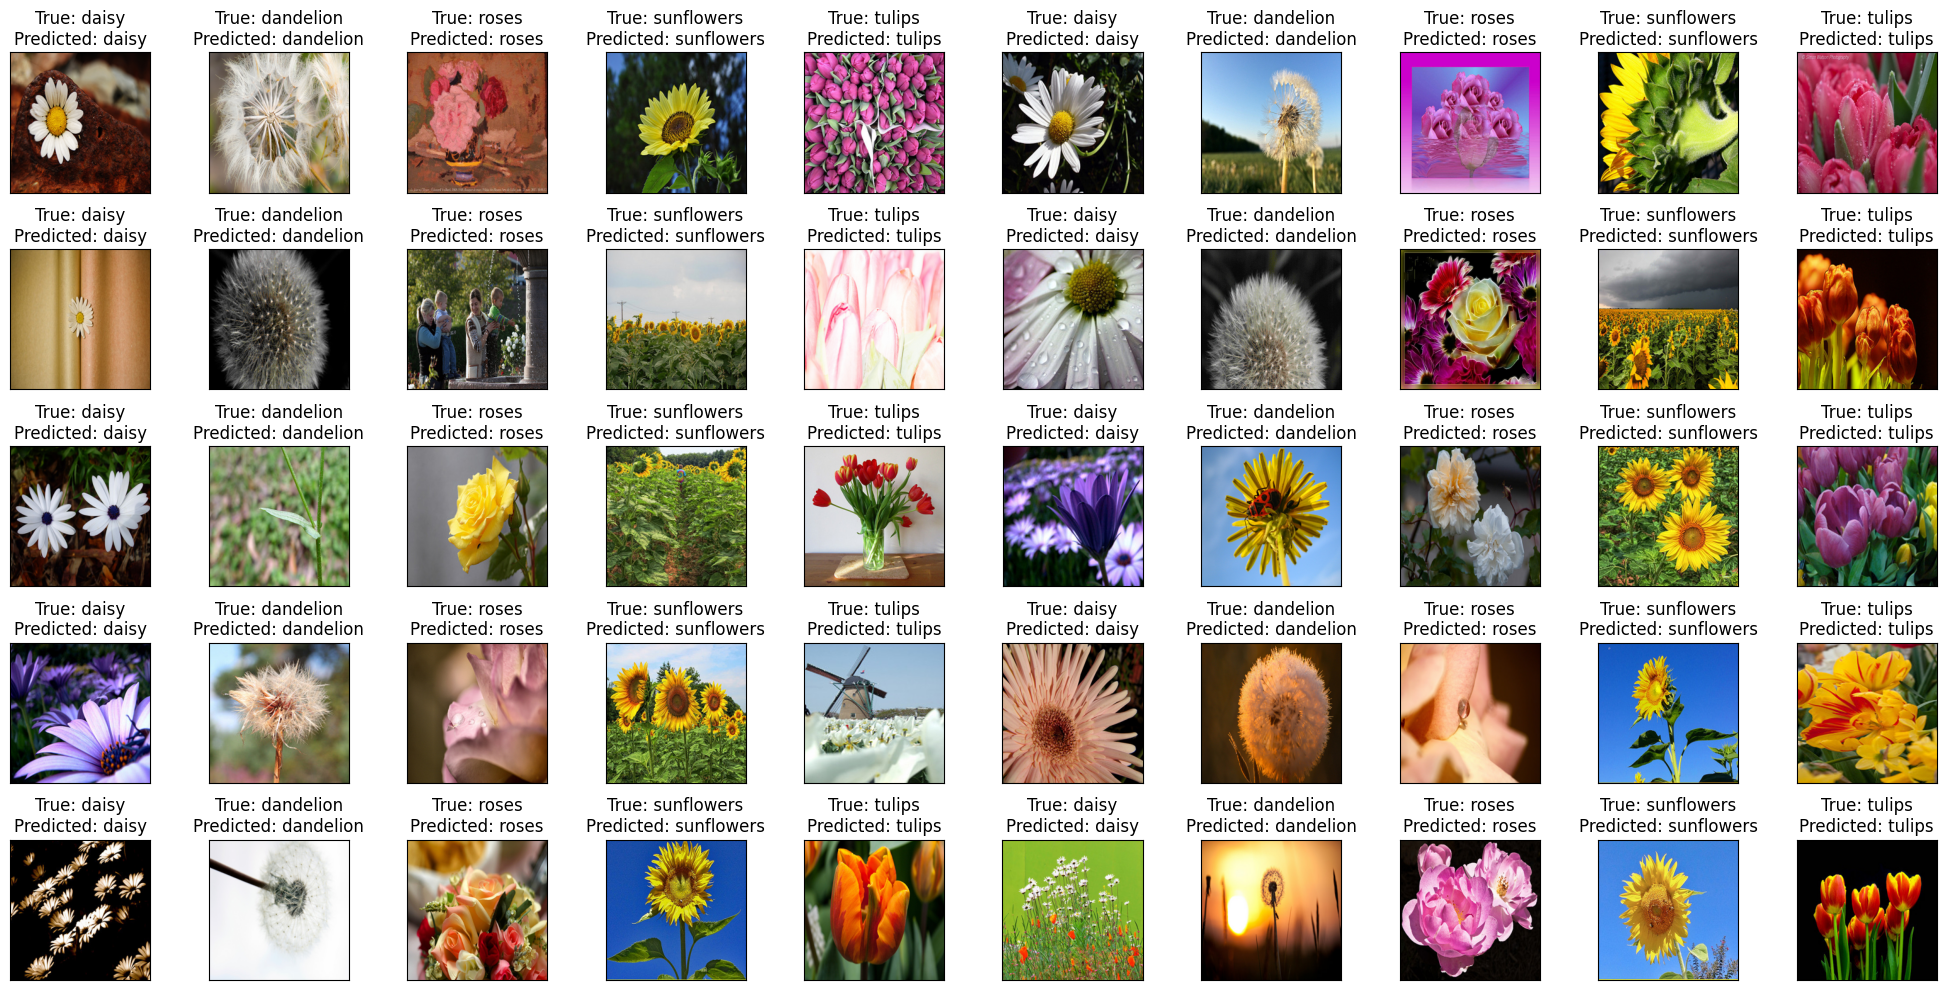

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the first 10 results in X_test
y_pred = model.predict(X_train[50:100])
y_pred_labels = [list(CATEGORIES.keys())[list(CATEGORIES.values()).index(np.argmax(p))] for p in y_pred]

# Convert the one-hot encoded true labels to labels
y_true_labels = list(y_train[50:100])
true_labels = []
for label in y_true_labels:
    true_labels.append(list(CATEGORIES.keys())[list(CATEGORIES.values()).index(np.argmax(label))])

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i+50])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"True: {true_labels[i]}\nPredicted: {y_pred_labels[i]}")

plt.tight_layout()
plt.show()
